# Time Series Analysis
## Data Gathering

In [1]:
import pandas as pd
import numpy as np
import os

cwd = os.getcwd()

In [2]:
data_url = [r"\Model Data\X Train.csv", r"\Model Data\X Test.csv", r"\Model Data\Y Train.csv", r"\Model Data\Y Test.csv"]

In [3]:
dataframes = [pd.read_csv(cwd + url) for url in data_url]
data_values = dataframes[:2]
data_labels = dataframes[2:]

data = pd.concat(data_values, ignore_index=True, axis=0)
labels = pd.concat(data_labels, ignore_index=True, axis=0)

joined_data = pd.concat([data, labels], axis=1)
joined_data = joined_data[joined_data.columns[~joined_data.columns.isin(["Counties_Idx"])]]

chrono_data = joined_data.sort_values(by=['Started_Date']).reset_index(drop=True)
chrono_data["Started_Date"] = chrono_data["Started_Date"].str.rsplit('-',n=1,expand=True)
chrono_data.drop('Started_Date',axis=1,inplace=True)
chrono_data.head()


,temperature,relative_humidity,wind_speed,wind_direction,total_precipitation,volumetric_soil_water_layer_1,Fire
0,-16.93,0.81,4.89,200.34,0.0,0.27,0
1,2.36,0.71,1.57,162.54,0.0,0.32,0
2,2.80,0.34,2.33,18.64,0.0,0.07,0
3,0.93,0.76,1.72,145.46,0.0,0.34,0
4,4.85,0.42,1.99,49.09,0.0,0.08,0


## Stationary Analysis

In [4]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

In [5]:
# null hypothesis that there isn't a statistically significant connection between out time series
'''
jTestResult = coint_johansen(chrono_data.drop(["Started_Date"], axis=1), -1, 1)
print("Trace Stat:", jTestResult.trace_stat, end="\n\n")
print("Eig Stat: ", jTestResult.eig)
'''
# Can reject the null hypothesis with 95% confidence for both trace and Eig Stat

'\njTestResult = coint_johansen(chrono_data.drop(["Started_Date"], axis=1), -1, 1)\nprint("Trace Stat:", jTestResult.trace_stat, end="\n\n")\nprint("Eig Stat: ", jTestResult.eig)\n'

In [6]:

#train_data = chrono_data.drop(["Started_Date"], axis=1)[:int(0.8 * len(chrono_data))]
#valid_data = chrono_data.drop(["Started_Date"], axis=1)[int(0.8 * len(chrono_data)):]


## LSTM 

In [7]:
from matplotlib import pyplot
from math import sqrt
import sklearn
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

In [8]:
trainEnd = int(0.6 * len(chrono_data))
validEnd = trainEnd + int(0.2 * len(chrono_data))
#scale value between [0,1]
scaler = sklearn.preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(chrono_data)

#how far back lstm will check
#since our data is messed up probably want big values around 60
how_far_back_to_look = 10

x_train,y_train, x_val,y_val=[],[],[],[]

for i in range(how_far_back_to_look,trainEnd):
    x_train.append(scaled_data[i-how_far_back_to_look:i,:6])
    y_train.append(scaled_data[i,6])
  
    

for i in range(trainEnd,len(scaled_data)):
    x_val.append(scaled_data[i-how_far_back_to_look:i,:6])
    y_val.append(scaled_data[i,6])

    
x_train,y_train = np.array(x_train),np.array(y_train)


x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],6))

x_val,y_val = np.array(x_val),np.array(y_val)

x_val = np.reshape(x_val,(x_val.shape[0],x_val.shape[1],6))


print("X_train shape: {}".format(x_train.shape))
#print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
#print("y_test shape: {}".format(y_test.shape))
print("x_val shape: {}".format(x_val.shape))
print("y_val shape: {}".format(y_val.shape))
#chrono_data = chrono_data.sample(frac=1).reset_index(drop=True)
'''
train_data = chrono_data[:trainEnd]
valid_data = chrono_data[trainEnd:validEnd]
test_data = chrono_data[validEnd:]



X_train, X_test, y_train, y_test = train_test_split(chrono_data.drop(['Fire'],axis=1), chrono_data['Fire'], test_size=0.2
                                                    , random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8)

X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

X_val = np.asarray(X_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)

print(chrono_data.shape)
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y val shape: {}".format(y_test.shape))
print(X_train)

train_X, train_Y = train_data[train_data.columns[~train_data.columns.isin(["Started_Date", "Fire"])]], train_data[["Fire"]]
valid_X, valid_Y = test_data[test_data.columns[~test_data.columns.isin(["Started_Date", "Fire"])]], test_data[["Fire"]]
test_X, test_Y = test_data[test_data.columns[~test_data.columns.isin(["Started_Date", "Fire"])]], test_data[["Fire"]]


train_X_values = train_X.values
train_X = train_X_values.reshape((train_X.shape[0], 1, train_X.shape[1]))

train_Y_values = train_Y.values
train_Y = train_Y_values.reshape(train_Y.shape[0])

valid_X_values = valid_X.values
valid_X = valid_X_values.reshape((valid_X.shape[0], 1, valid_X.shape[1]))

valid_Y_values = valid_Y.values
valid_Y = valid_Y_values.reshape(valid_Y.shape[0])

test_X_values = test_X.values
test_X = test_X_values.reshape((test_X.shape[0], 1, test_X.shape[1]))

test_Y_values = test_Y.values
test_Y = test_Y_values.reshape(test_Y.shape[0])
'''
'''
from collections import Counter

print(Counter(train_Y))
print(Counter(valid_Y))
print(Counter(test_Y))
print(train_X.shape)
'''

X_train shape: (2989, 10, 6)
y_train shape: (2989,)
x_val shape: (2000, 10, 6)
y_val shape: (2000,)


'\nfrom collections import Counter\n\nprint(Counter(train_Y))\nprint(Counter(valid_Y))\nprint(Counter(test_Y))\nprint(train_X.shape)\n'

In [9]:
model = Sequential()

model.add(LSTM(50,input_shape=( x_train.shape[1],6),return_sequences = True, activation='relu'))

model.add(Dropout(0.75))
model.add(LSTM(units = 50,return_sequences = True))
model.add(Dropout(0.75))
model.add(LSTM(units = 50))
model.add(Dropout(0.75))
model.add(Dense(25, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

opt = optimizers.Adam(learning_rate=0.005)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


#print(model.summary())





Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.54650, saving model to saved_models\saved_model_checkpoint


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 17s - loss: 0.6342 - accuracy: 0.7615 - val_loss: 0.7012 - val_accuracy: 0.5465 - 17s/epoch - 369ms/step
Epoch 2/200

Epoch 2: val_accuracy did not improve from 0.54650
47/47 - 1s - loss: 0.5620 - accuracy: 0.7681 - val_loss: 0.6737 - val_accuracy: 0.5465 - 629ms/epoch - 13ms/step
Epoch 3/200

Epoch 3: val_accuracy improved from 0.54650 to 0.74800, saving model to saved_models\saved_model_checkpoint


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 14s - loss: 0.4901 - accuracy: 0.7752 - val_loss: 0.5151 - val_accuracy: 0.7480 - 14s/epoch - 289ms/step
Epoch 4/200

Epoch 4: val_accuracy did not improve from 0.74800
47/47 - 1s - loss: 0.5036 - accuracy: 0.7504 - val_loss: 0.6053 - val_accuracy: 0.5465 - 644ms/epoch - 14ms/step
Epoch 5/200

Epoch 5: val_accuracy did not improve from 0.74800
47/47 - 1s - loss: 0.4756 - accuracy: 0.7681 - val_loss: 0.5726 - val_accuracy: 0.5465 - 650ms/epoch - 14ms/step
Epoch 6/200

Epoch 6: val_accuracy did not improve from 0.74800
47/47 - 1s - loss: 0.4660 - accuracy: 0.7681 - val_loss: 0.5687 - val_accuracy: 0.5465 - 643ms/epoch - 14ms/step
Epoch 7/200

Epoch 7: val_accuracy did not improve from 0.74800
47/47 - 1s - loss: 0.4653 - accuracy: 0.7681 - val_loss: 0.5572 - val_accuracy: 0.5465 - 641ms/epoch - 14ms/step
Epoch 8/200

Epoch 8: val_accuracy did not improve from 0.74800
47/47 - 1s - loss: 0.4595 - accuracy: 0.7695 - val_loss: 0.5564 - val_accuracy: 0.5465 - 641ms/epoch - 14ms/step
Ep

INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 13s - loss: 0.4391 - accuracy: 0.7765 - val_loss: 0.5132 - val_accuracy: 0.7960 - 13s/epoch - 286ms/step
Epoch 13/200

Epoch 13: val_accuracy did not improve from 0.79600
47/47 - 1s - loss: 0.4447 - accuracy: 0.7578 - val_loss: 0.5480 - val_accuracy: 0.5465 - 673ms/epoch - 14ms/step
Epoch 14/200

Epoch 14: val_accuracy did not improve from 0.79600
47/47 - 1s - loss: 0.4366 - accuracy: 0.7725 - val_loss: 0.5307 - val_accuracy: 0.7390 - 663ms/epoch - 14ms/step
Epoch 15/200

Epoch 15: val_accuracy improved from 0.79600 to 0.79950, saving model to saved_models\saved_model_checkpoint


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 13s - loss: 0.4264 - accuracy: 0.7775 - val_loss: 0.5088 - val_accuracy: 0.7995 - 13s/epoch - 281ms/step
Epoch 16/200

Epoch 16: val_accuracy improved from 0.79950 to 0.80550, saving model to saved_models\saved_model_checkpoint


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 13s - loss: 0.4331 - accuracy: 0.7715 - val_loss: 0.5031 - val_accuracy: 0.8055 - 13s/epoch - 287ms/step
Epoch 17/200

Epoch 17: val_accuracy did not improve from 0.80550
47/47 - 1s - loss: 0.4304 - accuracy: 0.7809 - val_loss: 0.5014 - val_accuracy: 0.8010 - 665ms/epoch - 14ms/step
Epoch 18/200

Epoch 18: val_accuracy did not improve from 0.80550
47/47 - 1s - loss: 0.4300 - accuracy: 0.7772 - val_loss: 0.5037 - val_accuracy: 0.7930 - 654ms/epoch - 14ms/step
Epoch 19/200

Epoch 19: val_accuracy did not improve from 0.80550
47/47 - 1s - loss: 0.4216 - accuracy: 0.7792 - val_loss: 0.5004 - val_accuracy: 0.8020 - 656ms/epoch - 14ms/step
Epoch 20/200

Epoch 20: val_accuracy did not improve from 0.80550
47/47 - 1s - loss: 0.4291 - accuracy: 0.7802 - val_loss: 0.4995 - val_accuracy: 0.8015 - 662ms/epoch - 14ms/step
Epoch 21/200

Epoch 21: val_accuracy did not improve from 0.80550
47/47 - 1s - loss: 0.4165 - accuracy: 0.7899 - val_loss: 0.4764 - val_accuracy: 0.7970 - 650ms/epoch - 14

INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 14s - loss: 0.4210 - accuracy: 0.7922 - val_loss: 0.4791 - val_accuracy: 0.8065 - 14s/epoch - 288ms/step
Epoch 24/200

Epoch 24: val_accuracy improved from 0.80650 to 0.80700, saving model to saved_models\saved_model_checkpoint


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 13s - loss: 0.4244 - accuracy: 0.7896 - val_loss: 0.4868 - val_accuracy: 0.8070 - 13s/epoch - 281ms/step
Epoch 25/200

Epoch 25: val_accuracy did not improve from 0.80700
47/47 - 1s - loss: 0.4092 - accuracy: 0.8160 - val_loss: 0.4662 - val_accuracy: 0.8065 - 676ms/epoch - 14ms/step
Epoch 26/200

Epoch 26: val_accuracy did not improve from 0.80700
47/47 - 1s - loss: 0.4287 - accuracy: 0.7732 - val_loss: 0.5440 - val_accuracy: 0.7155 - 672ms/epoch - 14ms/step
Epoch 27/200

Epoch 27: val_accuracy did not improve from 0.80700
47/47 - 1s - loss: 0.4139 - accuracy: 0.7976 - val_loss: 0.4889 - val_accuracy: 0.8050 - 668ms/epoch - 14ms/step
Epoch 28/200

Epoch 28: val_accuracy did not improve from 0.80700
47/47 - 1s - loss: 0.4110 - accuracy: 0.8009 - val_loss: 0.4735 - val_accuracy: 0.8045 - 666ms/epoch - 14ms/step
Epoch 29/200

Epoch 29: val_accuracy did not improve from 0.80700
47/47 - 1s - loss: 0.4072 - accuracy: 0.8016 - val_loss: 0.4750 - val_accuracy: 0.8045 - 680ms/epoch - 14

INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


INFO:tensorflow:Assets written to: saved_models\saved_model_checkpoint\assets


47/47 - 14s - loss: 0.4087 - accuracy: 0.8173 - val_loss: 0.4556 - val_accuracy: 0.8130 - 14s/epoch - 288ms/step
Epoch 31/200

Epoch 31: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.4024 - accuracy: 0.8140 - val_loss: 0.4670 - val_accuracy: 0.8105 - 671ms/epoch - 14ms/step
Epoch 32/200

Epoch 32: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.4013 - accuracy: 0.8110 - val_loss: 0.4695 - val_accuracy: 0.7990 - 675ms/epoch - 14ms/step
Epoch 33/200

Epoch 33: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.4096 - accuracy: 0.8267 - val_loss: 0.4626 - val_accuracy: 0.7945 - 687ms/epoch - 15ms/step
Epoch 34/200

Epoch 34: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.4055 - accuracy: 0.8230 - val_loss: 0.4820 - val_accuracy: 0.7920 - 666ms/epoch - 14ms/step
Epoch 35/200

Epoch 35: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3919 - accuracy: 0.8274 - val_loss: 0.4648 - val_accuracy: 0.7895 - 666ms/epoch - 14

47/47 - 1s - loss: 0.3335 - accuracy: 0.8692 - val_loss: 0.5082 - val_accuracy: 0.7675 - 664ms/epoch - 14ms/step
Epoch 77/200

Epoch 77: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3414 - accuracy: 0.8595 - val_loss: 0.5387 - val_accuracy: 0.7220 - 653ms/epoch - 14ms/step
Epoch 78/200

Epoch 78: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3391 - accuracy: 0.8628 - val_loss: 0.4964 - val_accuracy: 0.7850 - 649ms/epoch - 14ms/step
Epoch 79/200

Epoch 79: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3314 - accuracy: 0.8642 - val_loss: 0.4857 - val_accuracy: 0.7970 - 652ms/epoch - 14ms/step
Epoch 80/200

Epoch 80: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3627 - accuracy: 0.8438 - val_loss: 0.5010 - val_accuracy: 0.7915 - 655ms/epoch - 14ms/step
Epoch 81/200

Epoch 81: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3297 - accuracy: 0.8628 - val_loss: 0.5096 - val_accuracy: 0.7810 - 651ms/epoch - 14

Epoch 122/200

Epoch 122: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3285 - accuracy: 0.8685 - val_loss: 0.5127 - val_accuracy: 0.7830 - 662ms/epoch - 14ms/step
Epoch 123/200

Epoch 123: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3146 - accuracy: 0.8675 - val_loss: 0.5320 - val_accuracy: 0.7700 - 665ms/epoch - 14ms/step
Epoch 124/200

Epoch 124: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3214 - accuracy: 0.8692 - val_loss: 0.5418 - val_accuracy: 0.7570 - 662ms/epoch - 14ms/step
Epoch 125/200

Epoch 125: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3131 - accuracy: 0.8792 - val_loss: 0.5156 - val_accuracy: 0.7765 - 663ms/epoch - 14ms/step
Epoch 126/200

Epoch 126: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3106 - accuracy: 0.8752 - val_loss: 0.5297 - val_accuracy: 0.7800 - 667ms/epoch - 14ms/step
Epoch 127/200

Epoch 127: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.3172 -

47/47 - 1s - loss: 0.2857 - accuracy: 0.8862 - val_loss: 0.6116 - val_accuracy: 0.7370 - 674ms/epoch - 14ms/step
Epoch 168/200

Epoch 168: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.2831 - accuracy: 0.8899 - val_loss: 0.6061 - val_accuracy: 0.7415 - 695ms/epoch - 15ms/step
Epoch 169/200

Epoch 169: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.2706 - accuracy: 0.8973 - val_loss: 0.6027 - val_accuracy: 0.7530 - 677ms/epoch - 14ms/step
Epoch 170/200

Epoch 170: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.2719 - accuracy: 0.8923 - val_loss: 0.6105 - val_accuracy: 0.7535 - 675ms/epoch - 14ms/step
Epoch 171/200

Epoch 171: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.2901 - accuracy: 0.8876 - val_loss: 0.6348 - val_accuracy: 0.7360 - 679ms/epoch - 14ms/step
Epoch 172/200

Epoch 172: val_accuracy did not improve from 0.81300
47/47 - 1s - loss: 0.2676 - accuracy: 0.9000 - val_loss: 0.6481 - val_accuracy: 0.7370 - 676ms/

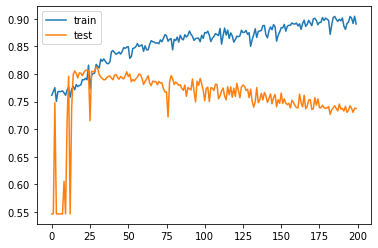

In [10]:

filepath = 'saved_models/saved_model_checkpoint'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True)]

history = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_val, y_val),
                    verbose=2, shuffle=False,callbacks=callbacks)

#history = model.fit(x_train, y_train, epochs=200, batch_size=64, validation_data=(x_val, y_val),
#                    verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [11]:

#.8115 lstm = 10
#lstm 15 works

In [12]:
loaded_model = tf.keras.models.load_model(filepath)
y_pred = np.argmax(loaded_model(x_val), axis=1)

accuracy_score = sklearn.metrics.accuracy_score(y_val, y_pred)
print(accuracy_score)

0.5465


In [13]:
1 - (sum(valid_Y) / len(valid_Y))

NameError: name 'valid_Y' is not defined

In [ ]:
print(valid_X.shape)